In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

In [2]:
dataFile = '../Data/us_equities_news_dataset_clean.csv'

In [3]:
dataFrame = pd.read_csv(dataFile)
dataFrame.head(1)

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,shares chinese electric car maker nio flying h...,news,happeningshares chinese electric car maker nio...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327


In [4]:
# columnsDict = dict(zip(dataFrame.columns, [str]*len(dataFrame.columns)))
# columnsDict.pop('Label')
# dataFrame = dataFrame.astype(columnsDict)

In [5]:
#cleanDataFrame = pd.DataFrame()
stockDF = pd.DataFrame(dataFrame.loc[dataFrame['ticker'] == 'AAPL'])
#appleDF = 
stockDF.rename(columns={'release_date':'Date','title':'Text'}, inplace=True)
#sorted(set(appleDF['release_date']))
stockDF.head()

,id,ticker,Text,category,content,Date,provider,url,article_id
49183,270698,AAPL,jpmorgan cautious ahead apple earnings,news,jpmorgan lifts apple aapl 2 9 target 296 300 a...,2020-01-28,Seeking Alpha,https://invst.ly/pnjv8,2068762
49184,270699,AAPL,faang fall get wall street love,news,kim khan investing com faang stocks predictabl...,2020-01-28,Investing.com,https://www.investing.com/news/stock-market-ne...,2068765
49185,270700,AAPL,wall street tumbles virus fuels economic worry,news,chuck mikolajczak new york reuters stocks suff...,2020-01-28,Reuters,https://www.investing.com/news/stock-market-ne...,2068311
49186,270701,AAPL,earnings watch apple amd take earnings stage a...,news,two best performing tech stocks 2019 set repor...,2020-01-28,MarketWatch,https://invst.ly/pnlbs,2068906
49187,270702,AAPL,day ahead top 3 things watch jan 28,news,yasin ebrahim kim khan 1 apple readies earning...,2020-01-28,Investing.com,https://www.investing.com/news/stock-market-ne...,2068907


In [6]:
def dateConvert(input):
    input = input.split('/')
    return input[2]+'-'+input[0]+'-'+input[1]

In [7]:
priceFile = '../Data/HistoricalData_AAPL.csv'
priceDF = pd.read_csv(priceFile, converters={'Date': dateConvert})
priceDF['Label'] = (priceDF['Open'] > priceDF['Close/Last']) * 1
priceDF.head()

,Date,Close/Last,Volume,Open,High,Low,Label
0,2022-12-05,$146.63,68826440,$147.77,$150.9199,$145.77,1
1,2022-12-02,$147.81,65447450,$145.96,$148,$145.65,0
2,2022-12-01,$148.31,71250420,$148.21,$149.13,$146.61,0
3,2022-11-30,$148.03,111380900,$141.395,$148.72,$140.55,0
4,2022-11-29,$141.17,83763800,$144.29,$144.81,$140.355,1


In [8]:
combinedDF = pd.DataFrame()
combinedDF['Date'] = priceDF['Date']
combinedDF['Label'] = priceDF['Label']
combinedDF = combinedDF.merge(stockDF[['Text','Date']], on='Date')

In [9]:
DAYS_SHIFTED = 0
combinedDF['Label'] = combinedDF.Label.shift(periods=DAYS_SHIFTED)
combinedDF = combinedDF.drop(range(DAYS_SHIFTED))
print(combinedDF.head())

         Date  Label                                               Text
3  2020-01-28    0.0  earnings watch apple amd take earnings stage a...
4  2020-01-28    0.0                day ahead top 3 things watch jan 28
5  2020-01-28    0.0  china apple tv service spotlight reports earnings
6  2020-01-28    0.0    stocks europe edge higher virus prompts caution
7  2020-01-28    0.0                 tech earnings expected turn around


In [10]:
N = len(combinedDF)
BATCH_SIZE = 128
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.2

trainSize = int(N * TRAIN_PERCENT)
validSize = int(trainSize * VALID_PERCENT)

train_df = combinedDF.iloc[:trainSize-validSize]
valid_df = combinedDF.iloc[trainSize-validSize:trainSize]
test_df = combinedDF.iloc[trainSize: N]

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Text'],train_df['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['Text'],valid_df['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['Text'],test_df['Label']))

train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [12]:
for text_batch, label_batch in valid_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch[i]}')
    print(f'Label : {label_batch[i]}')

Review: b'ebay shopify strike partnership new sales channel'
Label : 0.0


In [13]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [14]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
text_test = ['Stock markets are failing']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4518 6089 2024 7989  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999934  -0.05975785 -0.9992154   0.8614326  -0.9918146   0.49215725
 -0.7998322  -0.96311325  0.04429297  0.07501595 -0.2781724  -0.07062975]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[ 0.37704176  0.8024669  -3.1595538  ... -1.5464176  -1.3570802
   0.46216726]
 [-0.64480233  1.0490534  -0.9103106  ... -1.9362446  -1.6043748
   0.6558734 ]
 [-0.6935319   0.30529988 -0.39737198 ... -2.7002     -1.1346203
   0.9172526 ]
 ...
 [ 1.2762707   0.43299848 -0.5063809  ... -2.3409882  -0.75142634
   0.7291061 ]
 [ 1.3559846   0.767834   -0.6305102  ... -2.217216   -1.0172763
   0.72711873]
 [ 1.0703702   1.0503726  -0.79275036 ... -2.035972   -1.7825655
   0.76117617]]


In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5959452]], shape=(1, 1), dtype=float32)


In [20]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [22]:
epochs = 3
epsilson = 1e-3
#steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
init_lr = 3e-3

#optimizer = tf.optimizers.Adam(learning_rate=init_lr, epsilon=epsilson)
optimizer = tf.optimizers.Adadelta()

In [23]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [24]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=valid_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/3
88/88 [==============================] - 44s 483ms/step - loss: 0.7775 - binary_accuracy: 0.5066 - val_loss: 0.7446 - val_binary_accuracy: 0.5395
Epoch 2/3
88/88 [==============================] - 42s 482ms/step - loss: 0.7540 - binary_accuracy: 0.5113 - val_loss: 0.7235 - val_binary_accuracy: 0.5556
Epoch 3/3
88/88 [==============================] - 43s 483ms/step - loss: 0.7431 - binary_accuracy: 0.5200 - val_loss: 0.7100 - val_binary_accuracy: 0.5585


In [25]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

28/28 [==============================] - 4s 129ms/step - loss: 0.7100 - binary_accuracy: 0.5184
Loss: 0.7100167870521545
Accuracy: 0.5184443593025208


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


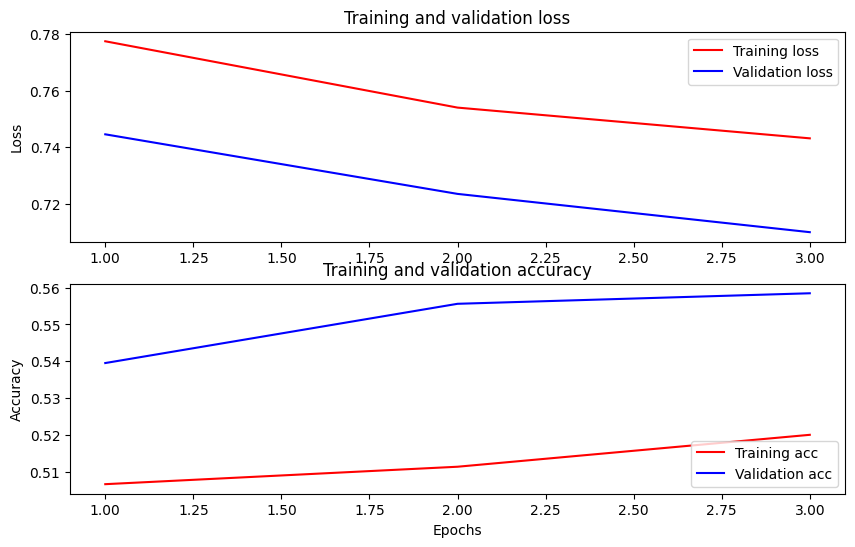

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'stock markets are failing',  # this is the same sentence tried earlier
    'world hunger is solved',
    'world war iii starts',
    'interest rates are falling',
    'does democracy work'
]

#reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

#print('Results from the saved model:')
#print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: stock markets are failing      : score: 0.493965
input: world hunger is solved         : score: 0.567307
input: world war iii starts           : score: 0.608312
input: interest rates are falling     : score: 0.521882
input: does democracy work            : score: 0.507581

